## 8. 프로젝트 : 개선된 U-Net 모델 만들기

U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.

2018년에 **U-Net++** 라는 논문이 나왔습니다.   
이 논문은 <span style='color:red'> 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.</span>

그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다.

* (참고) [U-Net++ 저자 블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)

<img align='center' width='50%' src='https://aiffelstaticprd.blob.core.windows.net/media/images/GC-5-P-UNPP.max-800x600.png'/>

## Step 1. KITTI 데이터셋 수집과 구축

다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다.   
U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다.   
8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

### 데이터 로더(data loader) 만들기

In [1]:
#필요한 라이브러리 로드 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

* 모듈과 패키지 : [참고](https://tensorflow.blog/회오리바람을-탄-파이썬/모듈과-패키지/)
  - 모듈 로딩: import 문
    - 명시적 모듈 임포팅 : 명시적으로 모듈을 임포팅, 네임스페이스는 모듈의 내용을 “.“으로 참조
      - import math
      - math.cos(math.pi)
    - 별칭을 사용한 명시적 모듈 임포팅 : 네임스페이스의 짧은 별칭을 사용해 임포트
      - import numpy as 
      - np.cos(np.pi)
    - 명시적 모듈 컨텐츠 임포팅 : 모듈 네임스페이스를 임포팅하는 것대신 모듈에서 몇 개의 컨텐츠만 임포팅
      - from math import cos, pi
      - cos(pi)
    - 모듈 컨텐츠 묵시적 임포팅 : 모듈 컨텐츠 전체를 로컬 네임스페이스로 임포팅
      - from math import *
      - sin(pi) ** 2 + cos(pi) ** 2
      

* The Model class : [참고](https://keras.io/api/models/model/#model-class), [참고2](https://www.tensorflow.org/guide/keras/functional?hl=ko)
  - import tensorflow as tf
    - inputs = tf.keras.Input(shape=(3,))
    - x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
    - outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
    - model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
* Keras layers API : [참고](https://keras.io/api/layers/)
  - from tensorflow.keras import layers
    - layer = layers.Dense(32, activation='relu')
    - inputs = tf.random.uniform(shape=(10, 20))
    - outputs = layer(inputs)

In [2]:
# albumentation을 사용한 augmentation 
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    # 훈련용 데이터일 경우
    if is_train:    
        # augmentation 기법을 확률적으로 적용
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(          # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    # 테스트용 데이터일 경우
    return Compose([       
                  Resize(          # 224X224로 resize만 수행
                      width=224,
                      height=224
                      )
                  ])

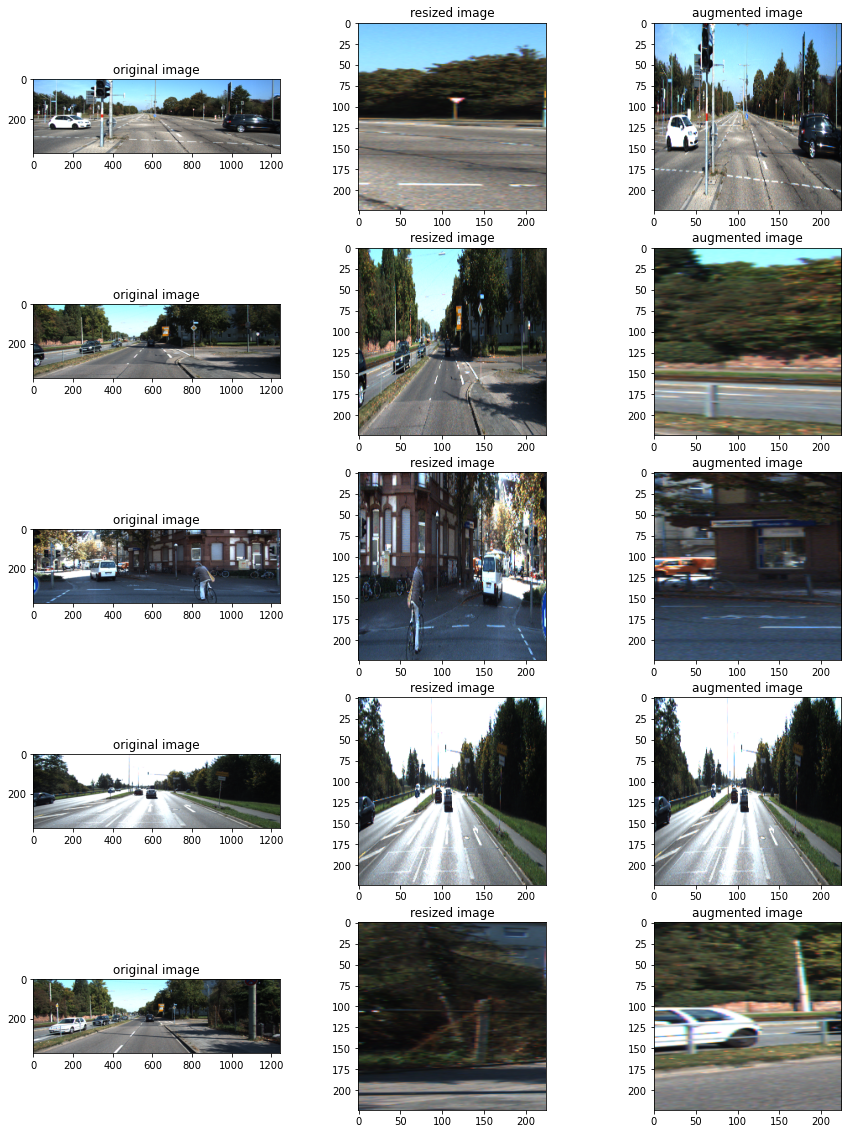

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(15, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    
    plt.subplot(5, 3, 3*i+1)
    plt.title("original image")
    plt.imshow(image)               # 왼쪽이 원본 이미지   
    plt.subplot(5, 3, 3*i+2)    
    plt.title("resized image")
    plt.imshow(resized["image"])    # 가운데가 resized된 이미지
    plt.subplot(5, 3, 3*i+3)
    plt.title("augmented image")
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

* **augmentation(` **image_data`)** : 
  - [참고: 함수 인자 `*args와 **kwargs`](https://brunch.co.kr/@princox/180)
  - [참고: 함수의 매개변수(parameter) 특징](https://ychae-leah.tistory.com/65)

  - 함수 인자의 순서 : **`일반 변수, *변수, **변수`**

  - **`*args`** 는 **`*arguments`** 의 줄임말
    - 여러 개의 인자를 함수로 받고자 할 때 사용
    - 함수 내부에서는 튜플로 받은 것처럼 인식한다

  - **` **kwargs`** 는 **` **keyword arguments`** 의 줄임말
    - (키워드 = 특정 값) 형태로 함수를 호출할 때 사용
    - 딕셔너리 형태로 {'키워드': '특정값'} 함수 내부로 전달한다

In [4]:
# generator 형태로 데이터셋 구성
class KittiGenerator(tf.keras.utils.Sequence):
    
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=4,           # 16 : OOM 발생
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
  
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
    
        if self.is_train:
            return data[:-30]
        return data[-30:]
        
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
  
    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
  
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net & U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다.   
이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

### U-Net 모델

<img align='center' width='60%' src='https://aiffelstaticprd.blob.core.windows.net/media/images/u-net_1kfpgqE.max-800x600.png'/>
<div style='text-align:center'> U-Net 구조 </div>

#### UNet 모델 구조 만들기

In [6]:
def conv_down(inputs, n_filter, stage, k_size=3, act='relu', pad='same', k_init='he_normal'):
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='conv'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(inputs)
    cd = layers.BatchNormalization()(cd)
    
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='conv'+stage+'2', activation=act, padding=pad, kernel_initializer=k_init)(cd)
    cd = layers.BatchNormalization()(cd)
    
    return cd


def conv_up(inputs, n_filter, mrg, stage, act='relu', pad='same', k_init='he_normal' ):
    cu = Conv2D(filters=n_filter, kernel_size=(2, 2), name='conv'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(UpSampling2D(size = (2,2))(inputs)) 
    cu = layers.BatchNormalization()(cu)
    cc = concatenate([mrg, cu], axis = 3)
    return cc

In [7]:
# U-Net 모델 구조 만들기
def build_model_unet(input_shape=(224, 224, 3)):
    model = None

    inputs = Input(input_shape)
  
    # Contracting Path
    cd1 = conv_down(inputs, n_filter=64, stage='dn11')
    mp1 = MaxPooling2D(pool_size=(2, 2))(cd1)

    cd2 = conv_down(mp1, n_filter=128, stage='dn21')
    mp2 = MaxPooling2D(pool_size=(2, 2))(cd2)
    
    cd3 = conv_down(mp2, n_filter=256, stage='dn31')
    mp3 = MaxPooling2D(pool_size=(2, 2))(cd3)
    
    cd4 = conv_down(mp3, n_filter=512, stage='dn41')
    do4 = Dropout(0.5)(cd4)
    mp4 = MaxPooling2D(pool_size=(2, 2))(do4)
    
    cd5 = conv_down(mp4, n_filter=1024, stage='dn51')
    do5 = Dropout(0.5)(cd5)
    
    
    # Expanding Path
    cu4 = conv_up(do5, n_filter=512, mrg=do4, stage='up4')  # MaxPooling2D 전의 층과 merge 시킨다.
    cd4_2 = conv_down(cu4, n_filter=512, stage='dn42')
    
    cu3 = conv_up(cd4_2, n_filter=256, mrg=cd3, stage='up3')
    cd3_2 = conv_down(cu3, n_filter=256, stage='dn32')
    
    cu2 = conv_up(cd3_2, n_filter=128, mrg=cd2, stage='up2')
    cd2_2 = conv_down(cu2, n_filter=128, stage='dn22')
    
    cu1 = conv_up(cd2_2, n_filter= 64, mrg=cd1, stage='up1')
    cd1_2 = conv_down(cu1, n_filter=64, stage='dn12')
    
    outs = Conv2D(filters=2, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(cd1_2)  
    outs = Conv2D(filters=1, kernel_size=1, activation='sigmoid')(outs)
  
    model = Model(inputs = inputs, outputs = outs)
    return model

In [8]:
# del model_unet

In [9]:
model_unet = build_model_unet()
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
convdn111 (Conv2D)              (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         convdn111[0][0]                  
__________________________________________________________________________________________________
convdn112 (Conv2D)              (None, 224, 224, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

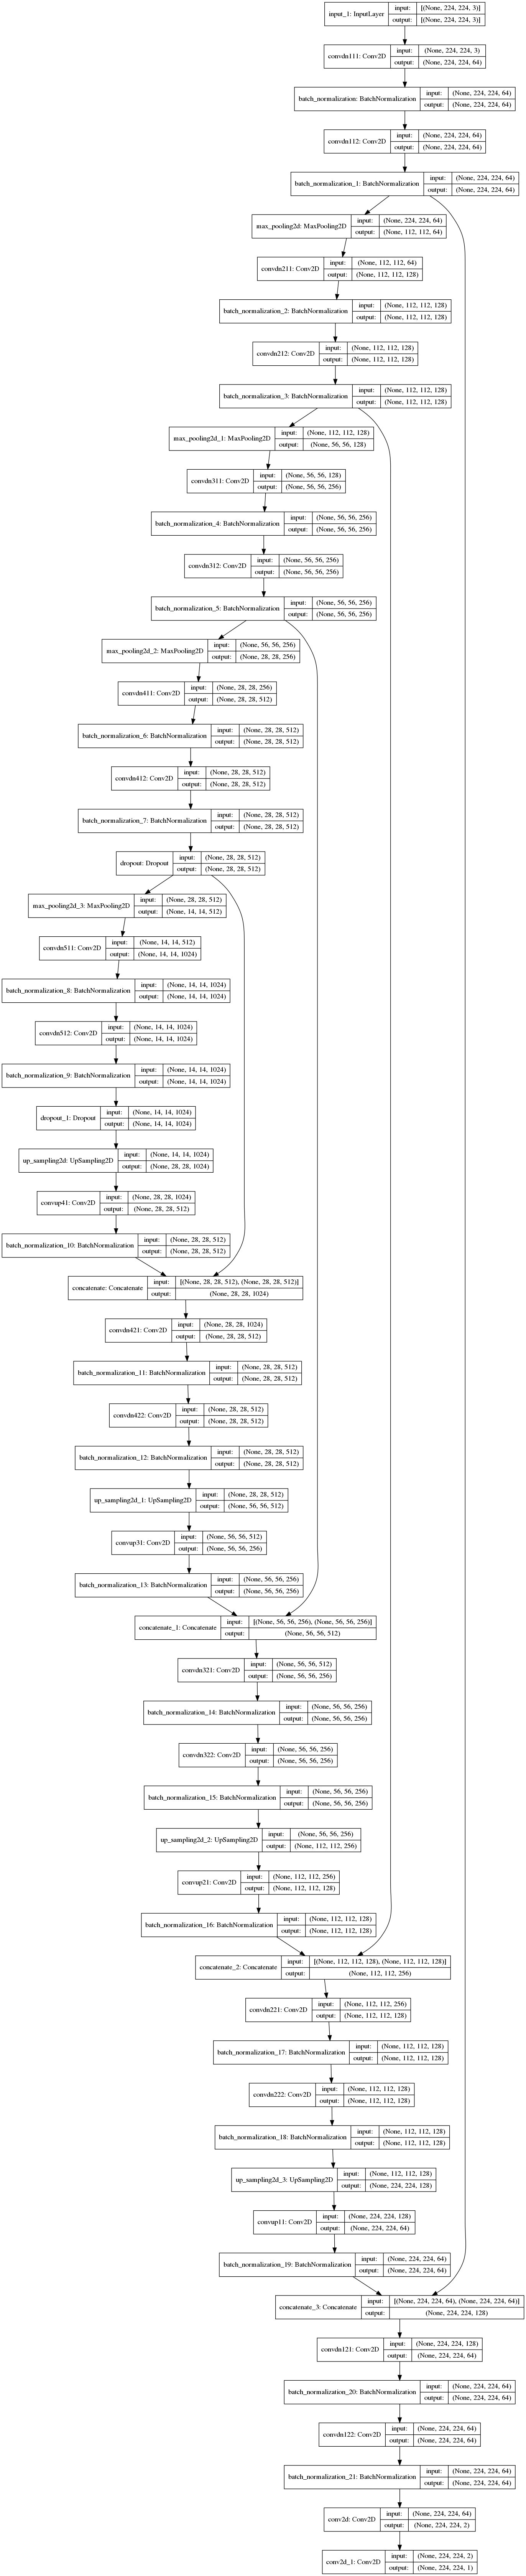

In [10]:
tf.keras.utils.plot_model(model_unet, show_shapes=True)

#### UNet 모델 학습하기

In [11]:
# 학습율 감소 함수
def lr_step_decay(epoch):
    init_lr = 0.0001          # self.flag.initial_learning_rate
    lr_decay = 0.5           # self.flag.learning_rate_decay_factor
    epoch_per_decay = 10     # self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

* [LearningRateScheduler로 학습률 제어하기](https://blog.naver.com/nostresss12/221544987534)
* [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler

# learning schedule callback
learning_rate = LearningRateScheduler(lr_step_decay)
callbacks_list = [learning_rate]

In [13]:
# 모델 학습하기
model_unet.compile(optimizer = Adam(lr = 1e-4), 
                   loss = 'binary_crossentropy',
                   metrics=['accuracy'])


history_unet = model_unet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    callbacks = callbacks_list,
    epochs=100,
 )

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 37s 214ms/step - loss: 0.5164 - accuracy: 0.8161 - val_loss: 0.4150 - val_accuracy: 0.8950
Epoch 2/100
43/43 [==============================] - 9s 205ms/step - loss: 0.2491 - accuracy: 0.9500 - val_loss: 0.6490 - val_accuracy: 0.4186
Epoch 3/100
43/43 [==============================] - 9s 201ms/step - loss: 0.1862 - accuracy: 0.9604 - val_loss: 0.6523 - val_accuracy: 0.9131
Epoch 4/100
43/43 [==============================] - 9s 205ms/step - loss: 0.1479 - accuracy: 0.9656 - val_loss: 0.6000 - val_accuracy: 0.9353
Epoch 5/100
43/43 [==============================] - 9s 205ms/step - loss: 0.1143 - accuracy: 0.9732 - val_loss: 0.2166 - val_accuracy: 0.9460
Epoch 6/100
43/43 [==============================] - 8s 196ms/step - loss: 0.1045 - accuracy: 0.9669 - val_loss: 0.2831 - val_accuracy: 0.9282
Epoch 7/100
43/43 [==============================] - 8s 196ms/step - loss: 0.1109 - accuracy: 0.9655 - val_loss: 0.1982 - val_accuracy: 0.973

Epoch 58/100
43/43 [==============================] - 9s 198ms/step - loss: 0.0361 - accuracy: 0.9886 - val_loss: 0.0607 - val_accuracy: 0.9759
Epoch 59/100
43/43 [==============================] - 9s 199ms/step - loss: 0.0374 - accuracy: 0.9883 - val_loss: 0.0629 - val_accuracy: 0.9751
Epoch 60/100
43/43 [==============================] - 9s 198ms/step - loss: 0.0354 - accuracy: 0.9890 - val_loss: 0.0587 - val_accuracy: 0.9771
Epoch 61/100
43/43 [==============================] - 9s 198ms/step - loss: 0.0400 - accuracy: 0.9859 - val_loss: 0.0642 - val_accuracy: 0.9758
Epoch 62/100
43/43 [==============================] - 9s 198ms/step - loss: 0.0493 - accuracy: 0.9834 - val_loss: 0.0597 - val_accuracy: 0.9781
Epoch 63/100
43/43 [==============================] - 9s 198ms/step - loss: 0.0399 - accuracy: 0.9887 - val_loss: 0.0561 - val_accuracy: 0.9796
Epoch 64/100
43/43 [==============================] - 9s 198ms/step - loss: 0.0388 - accuracy: 0.9867 - val_loss: 0.0596 - val_accuracy:

#### UNet 훈련 과정 시각화

In [14]:
#학습한 모델 저장
model_unet_path = dir_path + '/seg_model_unet.h5'
model_unet.save(model_unet_path)  

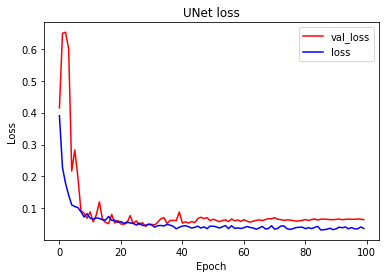

In [15]:
# 훈련 과정 시각화
plt.plot(history_unet.history['val_loss'], 'r')
plt.plot(history_unet.history['loss'], 'b')
plt.title('UNet loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'loss'], loc='upper right')
plt.show()

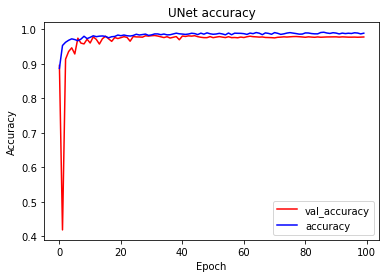

In [16]:
# 훈련 과정 시각화
plt.plot(history_unet.history['val_accuracy'], 'r')
plt.plot(history_unet.history['accuracy'], 'b')
plt.title('UNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='lower right')
plt.show()

* [line style or marke](https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html)

### U-Net++ 모델

* [참고1](https://engineer-mole.tistory.com/40)
* [참고2](https://github.com/CarryHJR/Nested-UNet)

* [참고3](https://github.com/MrGiovanni/UNetPlusPlus)
* [참고4](https://github.com/MrGiovanni/UNetPlusPlus/tree/master/keras/segmentation_models/unet)

* [UNet++ paper](https://arxiv.org/abs/1807.10165)
* [UNet++ code](https://github.com/MrGiovanni/UNetPlusPlus)
* [Nested-UNet](https://github.com/CarryHJR/Nested-UNet)
* [UNet 3+](https://github.com/ZJUGiveLab/UNet-Version)
* [Review UNet++](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)
* [FCN](https://gaussian37.github.io/vision-segmentation-fcn/)

<img align='center' width='80%' src='https://miro.medium.com/max/658/1*ExIkm6cImpPgpetFW1kwyQ.png'/>
<div style='text-align:center'> U-Net++ 구조 </div>

#### re-designed skip pathways

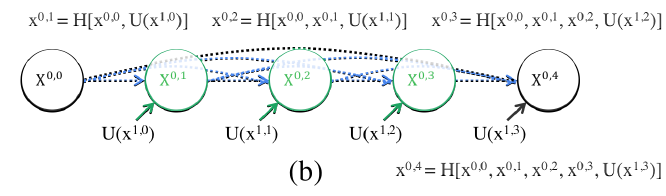
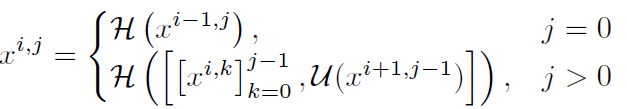


* <span style='color:red'> `H()`는 convolution 동작 다음의 활성화 함수이며,</span>       
* <span style='color:red'> `U()`는 up-sampling layer을 나타낸다. 그리고 </span>       
* <span style='color:red'> `[]`는 concatenation layer을 나타낸다.</span>   

* [참고](https://engineer-mole.tistory.com/40)

*  let $\textbf x^{i,j}$ denote the output of **node $X^{i,j}$** 
   - **i indexes** the down-sampling layer **along the encoder** and 
   - **j indexes** the convolution layer of the dense block **along the skip pathway**.


**`function H(·)`** is a **convolution operation** followed by an **activation function,**   
**`function U(·)`** denotes an **up-sampling layer**, and   
**`[ ]`** denotes the **concatenation layer**.  


Basically, 
* **`nodes at level j = 0`** receive **only one input** from the **previous layer of the encoder**; 
* **`nodes at level j = 1`** receive **two inputs**, 
  - both from the encoder sub-network but at two consecutive levels; and 
* **`nodes at level j > 1`** receive **(j + 1) inputs**, of which 
  - `j inputs` are the **outputs of the previous j nodes** in the **same skip pathway** 
  - and the `last input` is the **up-sampled output** from the **lower skip pathway**.
  

#### UNet++ 모델 구조 만들기

In [17]:
def conv_net(inputs, n_filter, stage, k_size=3, act='relu', pad='same', k_init='he_normal'):
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='cd'+stage+'1', activation=act, padding=pad, kernel_initializer=k_init)(inputs)
    cd = layers.BatchNormalization()(cd)
    
    cd = Conv2D(filters=n_filter, kernel_size=(k_size, k_size), name='cd'+stage+'2', activation=act, padding=pad, kernel_initializer=k_init)(cd)
    cd = layers.BatchNormalization()(cd)
    
    return cd


def ups_cctn(inputs, n_filter, mrg, stage, act='relu', pad='same', k_init='he_normal' ):
    cu = Conv2D(filters=n_filter, kernel_size=(2, 2), name='up'+stage, activation=act, padding=pad, kernel_initializer=k_init)(UpSampling2D(size = (2,2))(inputs)) 
    cu = layers.BatchNormalization()(cu)
    
    cc = concatenate([mrg, cu], axis = 3)
    
    return cc

* `tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest', **kwargs)` : 
  - Repeats the rows and columns of the data by `size[0]` and `size[1]` respectively.
  - `size` : Int, or tuple of 2 integers. The upsampling factors for rows and columns.
  - `interpolation` :	A string, one of nearest or bilinear.
  - [참고](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D)

* [UpSampling2D 와 Conv2DTranspose의 차이](http://machinelearningkorea.com/2019/08/25/upsampling2d-와-conv2dtranspose의-차이/)

* [How to use the UpSampling2D and Conv2DTranspose Layers in Keras](https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/)


In [18]:
def build_model_unet_pp(input_shape=(224, 224, 3)):
    model = None
    
    inputs = Input(input_shape)
      

    # x(n,0) node = H(x(n-1,0))   
    conv00 = conv_net(inputs, n_filter=64, stage='0_0')
    mxpl00 = MaxPooling2D(pool_size=(2, 2), name='pool00')(conv00)

    conv10 = conv_net(mxpl00, n_filter=128, stage='1_0')
    mxpl10 = MaxPooling2D(pool_size=(2, 2), name='pool10')(conv10)
    
    conv20 = conv_net(mxpl10, n_filter=256, stage='2_0')
    mxpl20 = MaxPooling2D(pool_size=(2, 2), name='pool20')(conv20)
    
    conv30 = conv_net(mxpl20, n_filter=512, stage='3_0')
    mxpl30 = MaxPooling2D(pool_size=(2, 2), name='pool30')(conv30)
    
    conv40 = conv_net(mxpl30, n_filter=1024, stage='4_0')
    drop40 = Dropout(0.5)(conv40)

    
    # x(n, 1) node = H([[x(n, 0)], U(x(n+1, 0))]) 
    conv01 = ups_cctn(conv10, n_filter=64, mrg=conv00, stage='0_1')      # MaxPooling2D 전의 층과 merge 시킨다.
    conv01 = conv_net(conv01, n_filter=64, stage='0_1')
    
    conv11 = ups_cctn(conv20, n_filter=128, mrg=conv10, stage='1_1')
    conv11 = conv_net(conv11, n_filter=128, stage='1_1')
    
    conv21 = ups_cctn(conv30, n_filter=256, mrg=conv20, stage='2_1')
    conv21 = conv_net(conv21, n_filter=256, stage='2_1')
    
    conv31 = ups_cctn(conv40, n_filter=512, mrg=conv30, stage='3_1')
    conv31 = conv_net(conv31, n_filter=512, stage='3_1') 
    
    
    # X(n, 2) node 
    conv02 = ups_cctn(conv11, n_filter=64, mrg=conv01, stage='0_2')      # MaxPooling2D 전의 층과 merge 시킨다.
    conv02 = concatenate([conv02, conv00], axis = 3)    
    conv02 = conv_net(conv02, n_filter=64, stage='0_2')

    conv12 = ups_cctn(conv21, n_filter=128, mrg=conv11, stage='1_2')      
    conv12 = concatenate([conv12, conv10], axis = 3)    
    conv12 = conv_net(conv12, n_filter=128, stage='1_2')

    conv22 = ups_cctn(conv31, n_filter=256, mrg=conv21, stage='2_2')  
    conv22 = concatenate([conv22, conv20], axis = 3)    
    conv22 = conv_net(conv22, n_filter=256, stage='2_2')


    # X(n, 3) node 
    conv03 = ups_cctn(conv12, n_filter=64, mrg=conv02, stage='0_3')      # MaxPooling2D 전의 층과 merge 시킨다.
    conv03 = concatenate([conv03, conv01, conv00], axis = 3)
    conv03 = conv_net(conv03, n_filter=64, stage='0_3')

    conv13 = ups_cctn(conv22, n_filter=128, mrg=conv12, stage='1_3')  
    conv13 = concatenate([conv13, conv11, conv10], axis = 3)    
    conv13 = conv_net(conv13, n_filter=128, stage='1_3')

    
    # X(n, 4) node 
    conv04 = ups_cctn(conv13, n_filter=64, mrg=conv03, stage='0_4')      # MaxPooling2D 전의 층과 merge 시킨다.
    conv04 = concatenate([conv04, conv02, conv01, conv00], axis = 3)    
    conv04 = conv_net(conv04, n_filter=64, stage='0_4')

    
    # outputs
#     output1 = Conv2D(filters=2, kernel_size=(3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(conv01)  
#     output1 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same')(conv01)

#     output2 = Conv2D(filters=2, kernel_size=(3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(conv02)  
#     output2 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same')(conv02)

#     output3 = Conv2D(filters=2, kernel_size=(3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(conv03)  
#     output3 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same')(conv03)

#     output4 = Conv2D(filters=2, kernel_size=(3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(conv04)  
    output4 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same')(conv04)
   
    
    
    # make model
    model = Model(inputs=inputs, outputs=[output4])
 
    return model

In [19]:
model_unet_pp = build_model_unet_pp()
model_unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
cd0_01 (Conv2D)                 (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 224, 224, 64) 256         cd0_01[0][0]                     
__________________________________________________________________________________________________
cd0_02 (Conv2D)                 (None, 224, 224, 64) 36928       batch_normalization_22[0][0]     
____________________________________________________________________________________________

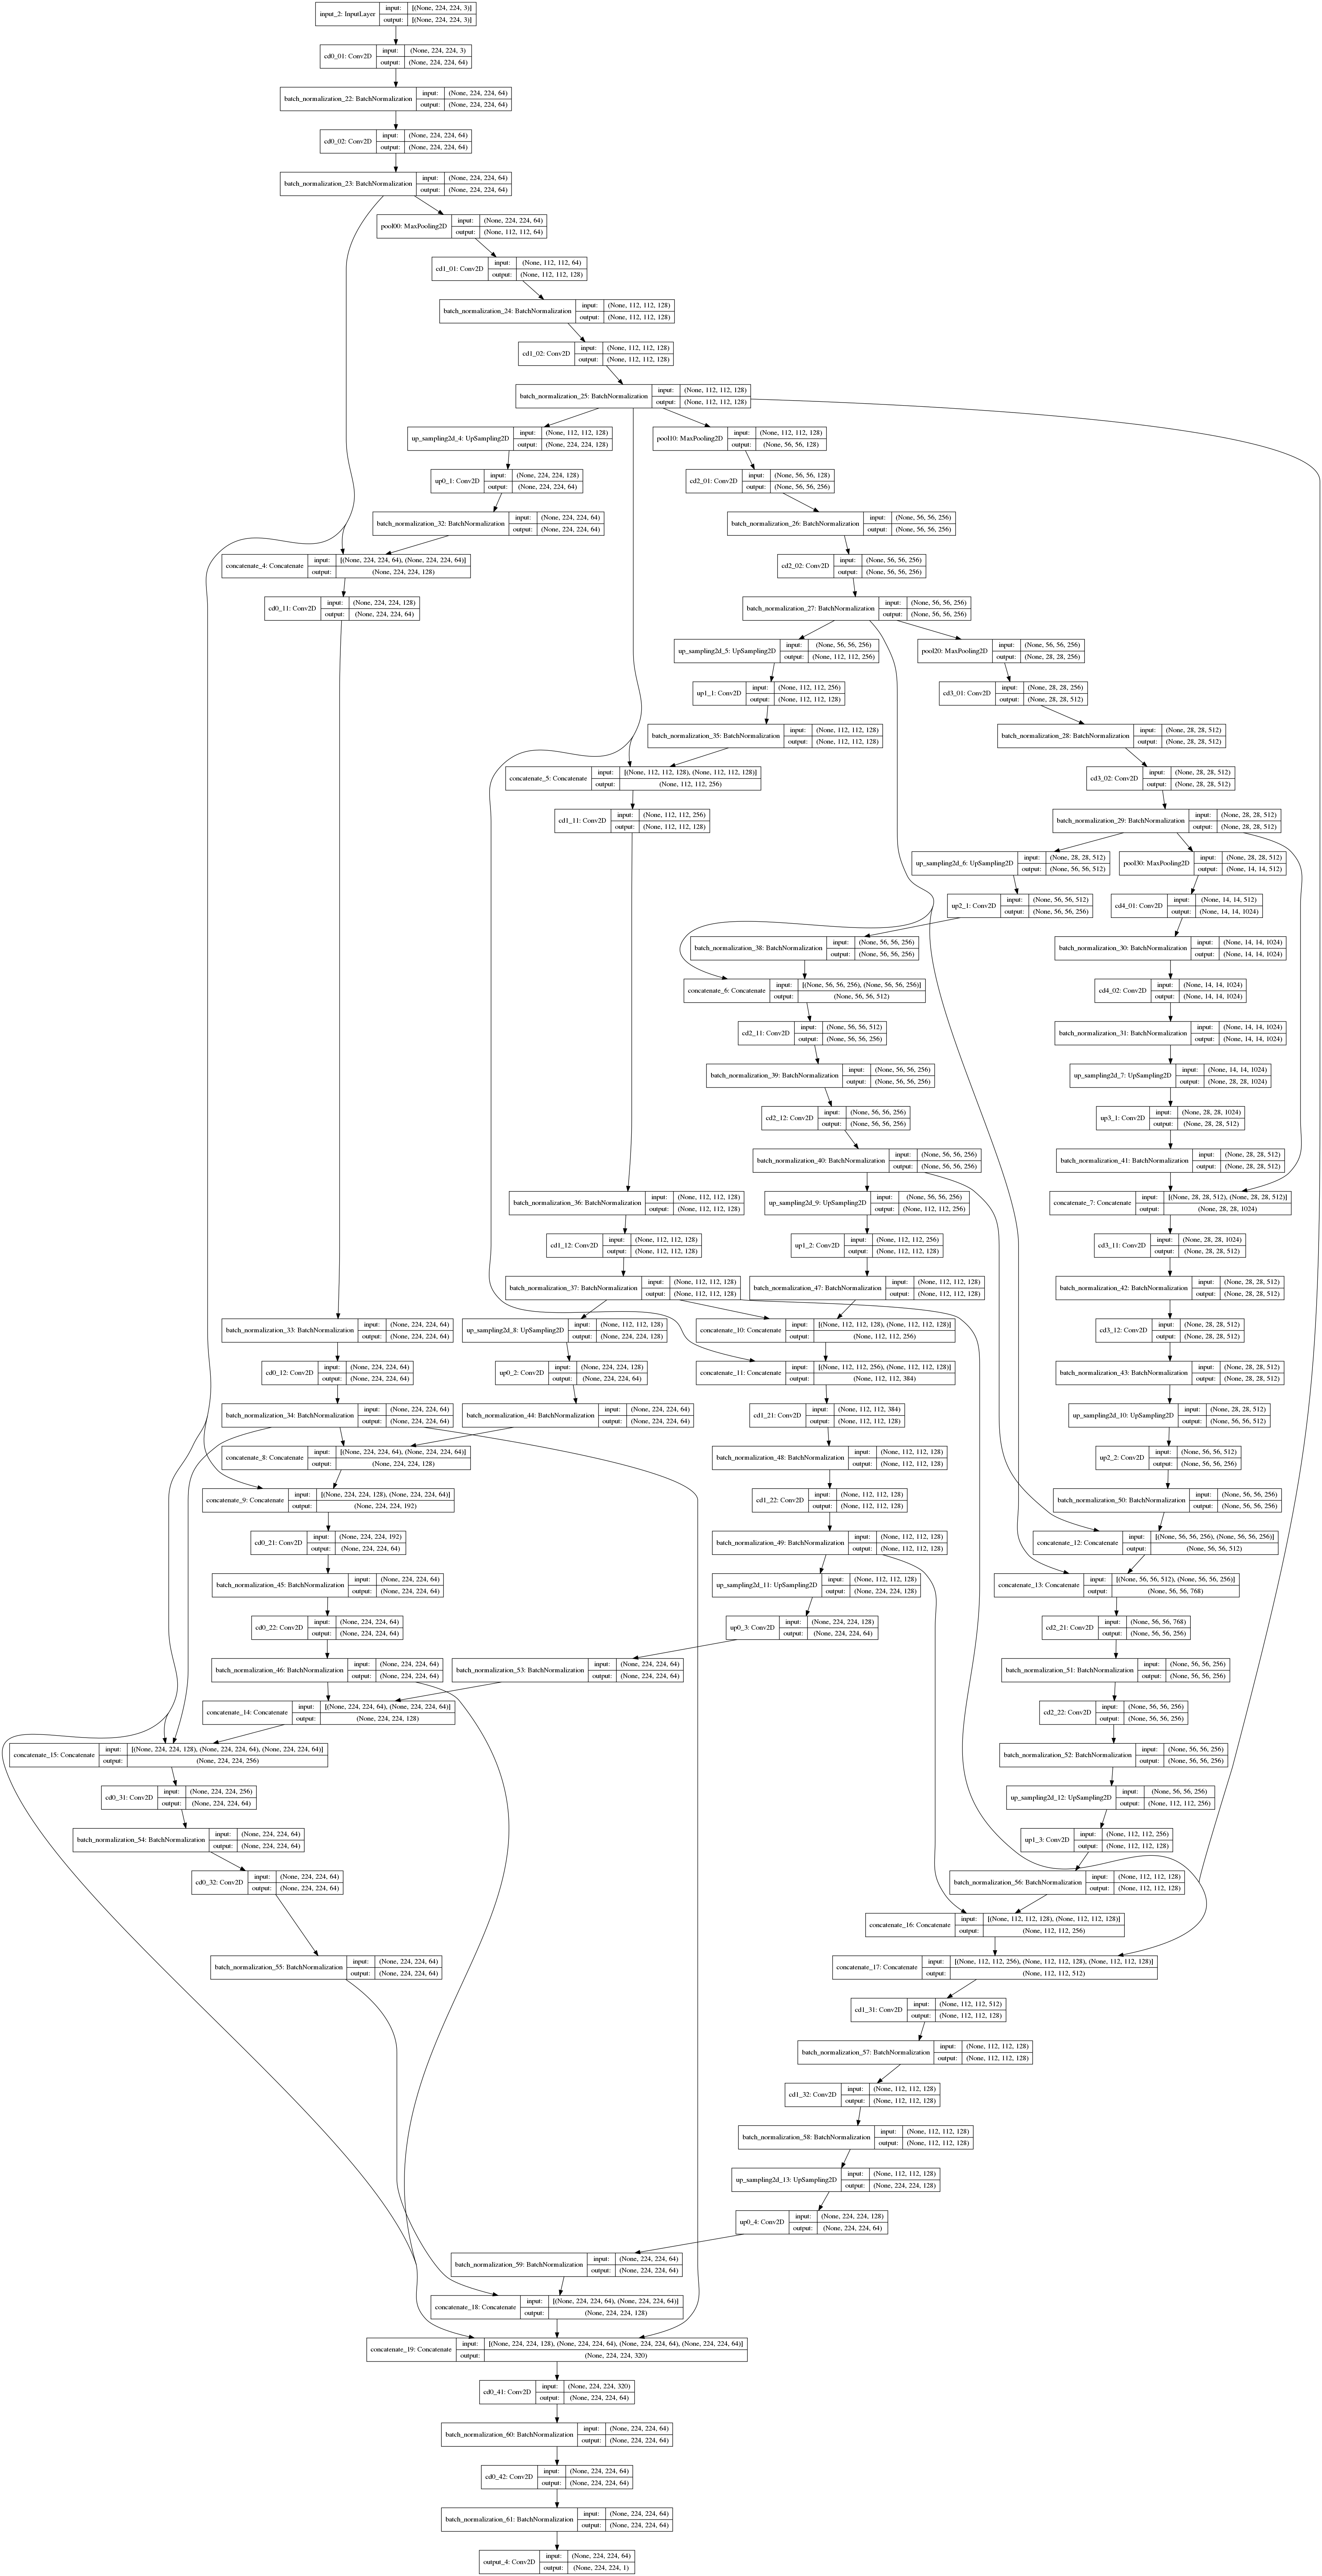

In [20]:
tf.keras.utils.plot_model(model_unet_pp, show_shapes=True)

#### UNet++ 모델 학습하기

In [21]:
# 학습율 감소 함수
def lr_step_decay(epoch):
    init_lr = 0.0001          # self.flag.initial_learning_rate
    lr_decay = 0.5           # self.flag.learning_rate_decay_factor
    epoch_per_decay = 10     # self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

In [22]:
from tensorflow.keras.callbacks import LearningRateScheduler

# learning schedule callback
learning_rate = LearningRateScheduler(lr_step_decay)
callbacks_list = [learning_rate]

In [23]:
# 모델 학습하기
model_unet_pp.compile(optimizer = Adam(lr = 1e-4), 
                   loss = 'binary_crossentropy',
                   metrics=['accuracy'])


history_unet_pp = model_unet_pp.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    callbacks = callbacks_list,
    epochs=100,
 )

Epoch 1/100
43/43 [==============================] - 34s 480ms/step - loss: 0.6944 - accuracy: 0.7601 - val_loss: 0.6410 - val_accuracy: 0.9104
Epoch 2/100
43/43 [==============================] - 20s 467ms/step - loss: 0.5314 - accuracy: 0.9210 - val_loss: 0.5234 - val_accuracy: 0.9482
Epoch 3/100
43/43 [==============================] - 20s 468ms/step - loss: 0.5225 - accuracy: 0.9362 - val_loss: 0.3239 - val_accuracy: 0.9351
Epoch 4/100
43/43 [==============================] - 20s 476ms/step - loss: 0.4590 - accuracy: 0.9314 - val_loss: 0.2685 - val_accuracy: 0.9586
Epoch 5/100
43/43 [==============================] - 20s 466ms/step - loss: 0.3846 - accuracy: 0.9590 - val_loss: 0.2338 - val_accuracy: 0.9357
Epoch 6/100
43/43 [==============================] - 20s 466ms/step - loss: 0.3598 - accuracy: 0.9676 - val_loss: 0.2527 - val_accuracy: 0.9358
Epoch 7/100
43/43 [==============================] - 20s 466ms/step - loss: 0.3972 - accuracy: 0.9644 - val_loss: 0.2295 - val_accuracy:

43/43 [==============================] - 20s 466ms/step - loss: 0.1851 - accuracy: 0.9855 - val_loss: 0.1447 - val_accuracy: 0.9787
Epoch 58/100
43/43 [==============================] - 20s 466ms/step - loss: 0.1430 - accuracy: 0.9859 - val_loss: 0.1415 - val_accuracy: 0.9794
Epoch 59/100
43/43 [==============================] - 20s 466ms/step - loss: 0.2040 - accuracy: 0.9857 - val_loss: 0.1401 - val_accuracy: 0.9780
Epoch 60/100
43/43 [==============================] - 20s 466ms/step - loss: 0.1784 - accuracy: 0.9835 - val_loss: 0.1354 - val_accuracy: 0.9777
Epoch 61/100
43/43 [==============================] - 20s 466ms/step - loss: 0.1675 - accuracy: 0.9862 - val_loss: 0.1444 - val_accuracy: 0.9781
Epoch 62/100
43/43 [==============================] - 20s 466ms/step - loss: 0.1889 - accuracy: 0.9837 - val_loss: 0.1468 - val_accuracy: 0.9787
Epoch 63/100
43/43 [==============================] - 20s 466ms/step - loss: 0.1644 - accuracy: 0.9858 - val_loss: 0.1509 - val_accuracy: 0.979

#### UNet++ 훈련 과정 시각화

In [24]:
#학습한 모델 저장
model_unet_pp_path = dir_path + '/seg_model_unet_pp.h5'
model_unet_pp.save(model_unet_pp_path)  

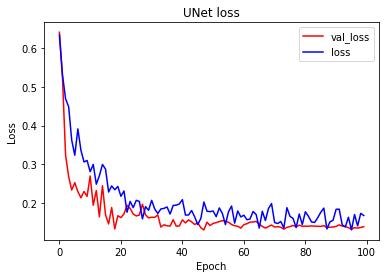

In [25]:
# 훈련 과정 시각화
plt.plot(history_unet_pp.history['val_loss'], 'r')
plt.plot(history_unet_pp.history['loss'], 'b')
plt.title('UNet loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'loss'], loc='upper right')
plt.show()

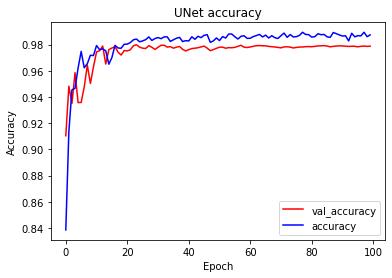

In [26]:
# 훈련 과정 시각화
plt.plot(history_unet_pp.history['val_accuracy'], 'r')
plt.plot(history_unet_pp.history['accuracy'], 'b')
plt.title('UNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='lower right')
plt.show()

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다.   
시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

### 시맨틱 세그멘테이션 모델 시각화

In [27]:
# 모델이 추론한 결과 오버레이
def get_output(model, preproc, image_path, output_path):
    
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)   # resize for test-data
    
    output = model(np.expand_dims(processed["image"]/255, axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255   # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    
    output = Image.blend(background, output, alpha=0.5)   # 이미지 오버레이
    
    output.show()
    return output

* `np.expand_dims(processed["image"]/255, axis=0)` : 이미지 파일을 불러와서 다차원 배열로 변환할 때 사용
  - 1. `numpy.reshape()` 을 이용한 차원 추가
  - 2. `numpy.expand_dims()` 을 이용한 차원 추가
  - 3. `numpy.newaxis` 을 이용한 차원 추가
  - [참고](https://rfriend.tistory.com/428)
  
  
* `(output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255` : 배열 형상을 바꿔줌
  - reshape, squeeze, expand_dims 함수
  - squeeze는 차원 중 사이즈가 1인 것을 찾아 스칼라값으로 바꿔 해당 차원을 제거한다.
  - [참고](https://blog.naver.com/wideeyed/221164750517)


* `PIL.Image.fromarray(obj, mode=None)` : 버퍼 프로토콜을 사용하여 배열 인터페이스를 내보내는 객체에서 이미지 메모리를 만듭니다.
  - NumPy에 이미지가있는 경우 Pillow 이미지로 변환하는 데 사용
  - [참고](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  
  
* `PIL.Image.blend(im1, im2, alpha)` : 상수 알파를 사용하여 두 입력 이미지 사이를 보간하여 새 이미지를 만듭니다
  - `out = image1 * (1.0 - alpha) + image2 * alpha`
  - [참고](https://pillow.readthedocs.io/en/stable/reference/Image.html)

#### UNet 모델 적용

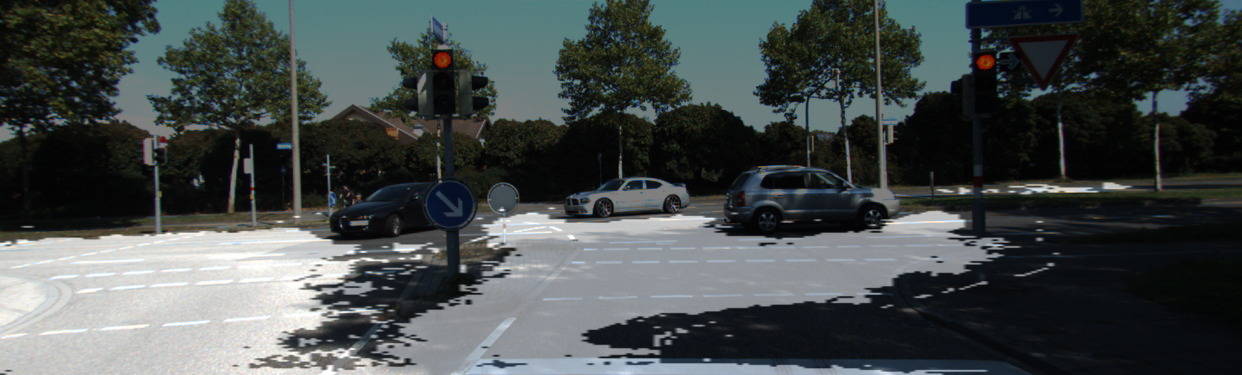

In [28]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model=model_unet, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

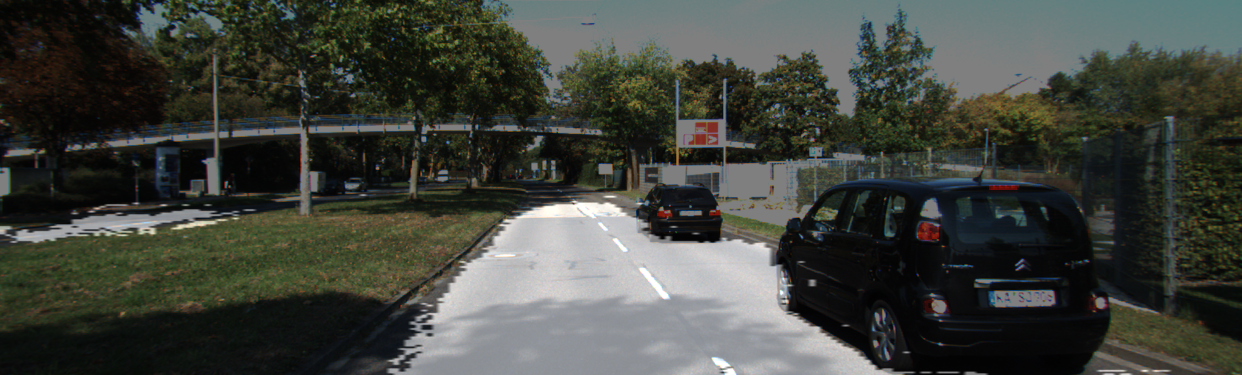

In [29]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 20    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model=model_unet, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

#### UNet++ 모델 적용

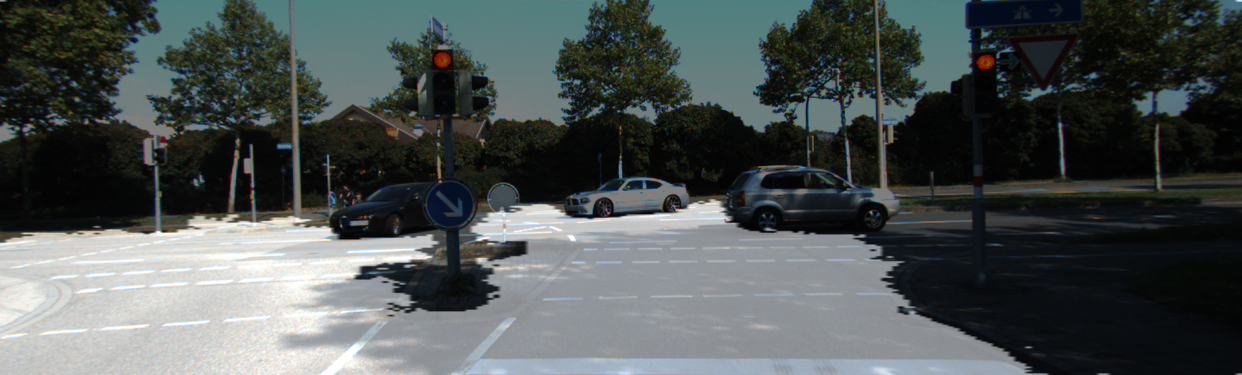

In [30]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model=model_unet_pp, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
 )

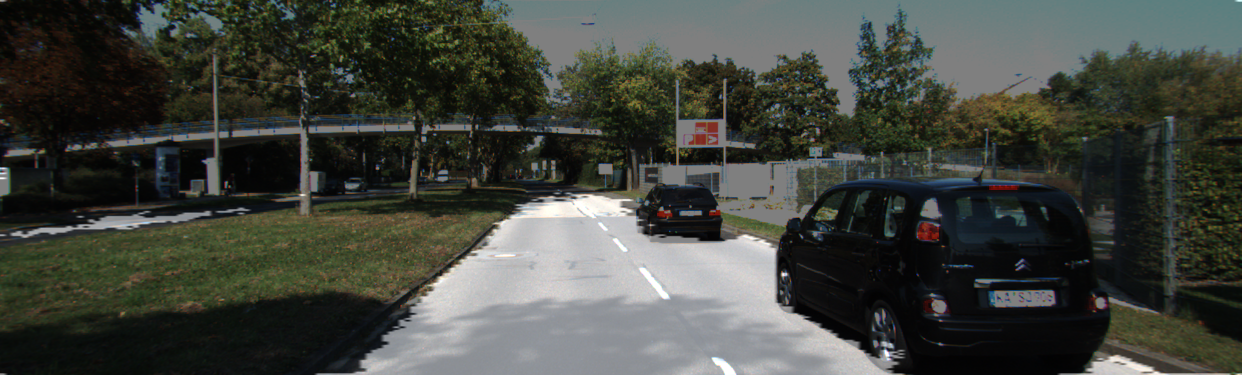

In [31]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 20    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model=model_unet_pp, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
 )

###  IoU(Intersection over Union)  계산

In [32]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [33]:
def get_output_iou(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### UNet 모델 적용

In [34]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output_iou(
     model=model_unet, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.613103


0.6131030598836118

In [35]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 20    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output_iou(
     model=model_unet, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.748358


0.7483583199107917

#### UNet++ 모델 적용

In [36]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_pp, prediction_pp, target_pp = get_output_iou(
     model=model_unet_pp, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target_pp, prediction_pp)

IoU : 0.802713


0.8027130086891292

In [37]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 20    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_pp, prediction_pp, target_pp = get_output_iou(
     model=model_unet_pp, 
     preproc=test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target_pp, prediction_pp)

IoU : 0.820410


0.8204102051025512

## 회고

* UNet++  관련 논문 및 코드를 보고 모델을 구현하기 위해서는 논문의 내용을 충분히 숙지해야만 한다는 것을 배웠다.

* UNet++ 의 출력이 4개로 구성되어 있는데 X(0,4) 만으로 충분하지 않을까 생각하고 있다.
  - 4개 모두 output으로 사용하면 사용하는데 에러가 발생하였다.

* generator 함수를 이용하여 데이터를 생성하는 것과 loss 함수를 정의 하는 것을 좀 더 공부해야겠다.
  - learning rate 값을 학습하면서 조정하는 것이 overfitting 을 방지하는데 큰 몫을 하였다.
  - 배치크기로 들어오는 것이기 때문에 BN을 수행하는 것이 좋을 것 같다.